In [17]:
import pandas as pd
import numpy as np
import torch
from tdc.single_pred.adme import ADME
from tdc import Evaluator
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
from rdkit import Chem
from rdkit.Chem import AllChem
from matplotlib import pyplot as plt
from IPython import display

from typing import List, Tuple


class Featurizer:
    def __init__(self, y_column, smiles_col='Drug', **kwargs):
        self.y_column = y_column
        self.smiles_col = smiles_col
        self.__dict__.update(kwargs)
    
    def __call__(self, df):
        raise NotImplementedError()

In [18]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader


def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise ValueError("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


from rdkit.Chem import rdMolDescriptors

class GraphFeaturizer(Featurizer):
    def __call__(self, df, getRepresentation):
        graphs = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            
            edges = []
            for bond in mol.GetBonds():
                begin = bond.GetBeginAtomIdx()
                end = bond.GetEndAtomIdx()
                edges.append((begin, end))  # TODO: Add edges in both directions
            edges = np.array(edges)
            
            nodes = []
            for atom in mol.GetAtoms():
                # print(atom.GetAtomicNum(), atom.GetNumImplicitHs(), atom.GetTotalNumHs(), atom.GetSymbol(), atom.GetNumExplicitHs(), atom.GetTotalValence())
                results = getRepresentation(atom)
                # print(results)
                nodes.append(results)
            nodes = np.array(nodes)
            
            graphs.append((nodes, edges.T))
            labels.append(y)
        labels = np.array(labels)
        return [Data(
            x=torch.FloatTensor(x), 
            edge_index=torch.LongTensor(edge_index), 
            y=torch.FloatTensor([y])
        ) for ((x, edge_index), y) in zip(graphs, labels)]

In [19]:
def defaultRepresentation(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(11)) + one_of_k_encoding(
                    atom.GetDegree(), range(11)
                ) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(), range(11)
                ) + [atom.GetIsAromatic()] + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(11)
                ) + [atom.GetNumImplicitHs(), atom.GetFormalCharge(), atom.GetNumRadicalElectrons(), atom.IsInRing()] # TODO: Add atom features as a list, you can use one_of_k_encodings defined above

def representation1(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(12)) + one_of_k_encoding_unk(
                    atom.GetDegree(), range(6)) + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(5)
                ) + [atom.GetFormalCharge(), atom.IsInRing(), atom.GetIsAromatic()]

def representation10(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(12)) + one_of_k_encoding_unk(
                    atom.GetDegree(), range(6)) + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(5)
                ) + [atom.IsInRing(), atom.GetIsAromatic()]

def representationAll(atom):
    return one_of_k_encoding_unk(atom.GetAtomicNum(), range(12)) + one_of_k_encoding_unk(
                    atom.GetDegree(), range(6)) + one_of_k_encoding_unk(
                    atom.GetTotalNumHs(), range(5)) + one_of_k_encoding_unk(
                    atom.GetImplicitValence(), range(6))  + one_of_k_encoding_unk(
                    atom.GetHybridization(),
                    [
                        Chem.rdchem.HybridizationType.SP, Chem.rdchem.HybridizationType.SP2,
                        Chem.rdchem.HybridizationType.SP3, Chem.rdchem.HybridizationType.SP3D,
                        Chem.rdchem.HybridizationType.SP3D2
                    ]
                ) + [atom.GetFormalCharge(), atom.IsInRing(), atom.GetIsAromatic()
                     ] + [atom.GetNumRadicalElectrons()]

def printProperties(atom):
    print("=========")
    print("GetDegree", atom.GetDegree())
    print("GetImplicitValence", atom.GetImplicitValence())
    print("GetAtomicNum", atom.GetAtomicNum())
    print("GetTotalNumHs", atom.GetTotalNumHs())
    print("GetNumImplicitHs", atom.GetNumImplicitHs())
    print("GetNeighbors", atom.GetNeighbors())
    print("GetNumExplicitHs", atom.GetNumExplicitHs())
    print("GetTotalDegree", atom.GetTotalDegree())
    print("GetTotalNumHs", atom.GetTotalNumHs())
    print("GetTotalValence", atom.GetTotalValence())

In [20]:
class ECFPFeaturizer(Featurizer):
    def __init__(self, y_column, radius=2, length=1024, **kwargs):
        self.radius = radius
        self.length = length
        super().__init__(y_column, **kwargs)
    
    def __call__(self, df):
        fingerprints = []
        labels = []
        for i, row in df.iterrows():
            y = row[self.y_column]
            smiles = row[self.smiles_col]
            mol = Chem.MolFromSmiles(smiles)
            fp = AllChem.GetMorganFingerprintAsBitVect(mol, self.radius, nBits=self.length)
            fingerprints.append(fp)
            labels.append(y)
        fingerprints = np.array(fingerprints)
        labels = np.array(labels)
        return fingerprints, labels

dataset = pd.read_csv("./datasets/esol.csv")

from sklearn.utils import shuffle
dataset = shuffle(dataset)
train_dataset = dataset[:500]
val_dataset = dataset[500:800]
test_dataset = dataset[800:1100]

In [21]:
rmse = Evaluator(name = 'RMSE')

featurizer = ECFPFeaturizer(y_column='measured log solubility in mols per litre', smiles_col="smiles")
X_train, y_train = featurizer(train_dataset)
X_valid, y_valid = featurizer(val_dataset)
X_test, y_test = featurizer(test_dataset)

featurizer = GraphFeaturizer(y_column='measured log solubility in mols per litre', smiles_col="smiles")

graph = featurizer(test_dataset.iloc[:1], representationAll)[0]

In [22]:
from torch_geometric.loader import DataLoader as GraphDataLoader


# prepare data loaders
batch_size = 64

train_loader1 = GraphDataLoader(featurizer(train_dataset, representation1), batch_size=batch_size, shuffle=True)
valid_loader1 = GraphDataLoader(featurizer(val_dataset, representation1), batch_size=batch_size)
test_loader1 = GraphDataLoader(featurizer(test_dataset, representation1), batch_size=batch_size)

train_loader10 = GraphDataLoader(featurizer(train_dataset, representation10), batch_size=batch_size, shuffle=True)
valid_loader10 = GraphDataLoader(featurizer(val_dataset, representation10), batch_size=batch_size)
test_loader10 = GraphDataLoader(featurizer(test_dataset, representation10), batch_size=batch_size)

train_loader = GraphDataLoader(featurizer(train_dataset, representationAll), batch_size=batch_size, shuffle=True)
valid_loader = GraphDataLoader(featurizer(val_dataset, representationAll), batch_size=batch_size)
test_loader = GraphDataLoader(featurizer(test_dataset, representationAll), batch_size=batch_size)

In [23]:
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool as gap

In [24]:
#warstwa attention pooling
class MyAttentionModule3(torch.nn.Module): # zakladamy ze atom ma 49 featerow
    def __init__(self, groupFeatures=1):
        super().__init__()
        self.groupFeatures = groupFeatures
        self.gates = torch.nn.ModuleDict({ # do wyliczenia atencji dla kazdej grupy cech - jest ich 9
            'AtomicNum': GCNConv(12, 1),
            'Degree': GCNConv(6, 1),
            'TotalNumHs': GCNConv(5, 1),
            'ImplicitValence': GCNConv(6, 1),
            'Hybridization': GCNConv(5, 1),
            'FormalCharge': GCNConv(1, 1),
            'IsInRing': GCNConv(1, 1),
            'IsAromatic': GCNConv(1, 1),
            'NumRadicalElectrons': GCNConv(1, 1)
        })
        
        self.feats = torch.nn.ModuleDict({ # do transformacji grupy cech w wektor, na razie dziala tylko dla groupFeatures=1
            'AtomicNum': torch.nn.Linear(12, groupFeatures),
            'Degree': torch.nn.Linear(6, groupFeatures),
            'TotalNumHs': torch.nn.Linear(5, groupFeatures),
            'ImplicitValence': torch.nn.Linear(6, groupFeatures),
            'Hybridization': torch.nn.Linear(5, groupFeatures),
            'FormalCharge': torch.nn.Linear(1, groupFeatures),
            'IsInRing': torch.nn.Linear(1, groupFeatures),
            'IsAromatic': torch.nn.Linear(1, groupFeatures),
            'NumRadicalElectrons': torch.nn.Linear(1, groupFeatures)
        })

    def forward(self, x, edge_index, batch):
        gates = []
        gates.append(self.gates['AtomicNum'](x[:,0:12], edge_index))
        gates.append(self.gates['Degree'](x[:,12:18], edge_index))
        gates.append(self.gates['TotalNumHs'](x[:,18:23], edge_index))
        gates.append(self.gates['ImplicitValence'](x[:,23:29], edge_index))
        gates.append(self.gates['Hybridization'](x[:,29:34], edge_index))
        gates.append(self.gates['FormalCharge'](x[:,34:35], edge_index))
        gates.append(self.gates['IsInRing'](x[:,35:36], edge_index))
        gates.append(self.gates['IsAromatic'](x[:,36:37], edge_index))
        gates.append(self.gates['NumRadicalElectrons'](x[:,37:38], edge_index))
        logits = torch.cat(gates, dim=-1)
        attention = torch.softmax(logits, dim=-1).unsqueeze(-1)
        
        subgroups = []
        subgroups.append(self.feats['AtomicNum'](x[:,0:12]) * attention[:,0])
        subgroups.append(self.feats['Degree'](x[:,12:18]) * attention[:,1])
        subgroups.append(self.feats['TotalNumHs'](x[:,18:23]) * attention[:,2])
        subgroups.append(self.feats['ImplicitValence'](x[:,23:29]) * attention[:,3])
        subgroups.append(self.feats['Hybridization'](x[:,29:34]) * attention[:,4])
        subgroups.append(self.feats['FormalCharge'](x[:,34:35]) * attention[:,5])
        subgroups.append(self.feats['IsInRing'](x[:,35:36]) * attention[:,6])
        subgroups.append(self.feats['IsAromatic'](x[:,36:37]) * attention[:,7])
        subgroups.append(self.feats['NumRadicalElectrons'](x[:,37:38]) * attention[:,8])
        x = torch.stack(subgroups, dim=-2)
        x = torch.sum(x, dim=-2)
        
        return x, attention

In [25]:
def attSequential(n_feats):
    return torch.nn.Sequential(torch.nn.Linear(n_feats, 1),
                       torch.nn.BatchNorm1d(1), torch.nn.ReLU(),
                       torch.nn.Linear(1, 1), torch.nn.ReLU())

In [26]:
#warstwa attention pooling
class MyAttentionModule4(torch.nn.Module): # zakladamy ze atom ma 49 featerow
    def __init__(self, groupFeatures=1):
        super().__init__()
        self.groupFeatures = groupFeatures
        self.gates = torch.nn.ModuleDict({ # do wyliczenia atencji dla kazdej grupy cech - jest ich 9
            'AtomicNum': GINConv(attSequential(12), train_eps=True),
            'Degree': GINConv(attSequential(6), train_eps=True),
            'TotalNumHs': GINConv(attSequential(5), train_eps=True),
            'ImplicitValence': GINConv(attSequential(6), train_eps=True),
            'Hybridization': GINConv(attSequential(5), train_eps=True),
            'FormalCharge': GINConv(attSequential(1), train_eps=True),
            'IsInRing': GINConv(attSequential(1), train_eps=True),
            'IsAromatic': GINConv(attSequential(1), train_eps=True),
            'NumRadicalElectrons': GINConv(attSequential(1), train_eps=True)
        })
        
        self.feats = torch.nn.ModuleDict({ # do transformacji grupy cech w wektor, na razie dziala tylko dla groupFeatures=1
            'AtomicNum': torch.nn.Linear(12, groupFeatures),
            'Degree': torch.nn.Linear(6, groupFeatures),
            'TotalNumHs': torch.nn.Linear(5, groupFeatures),
            'ImplicitValence': torch.nn.Linear(6, groupFeatures),
            'Hybridization': torch.nn.Linear(5, groupFeatures),
            'FormalCharge': torch.nn.Linear(1, groupFeatures),
            'IsInRing': torch.nn.Linear(1, groupFeatures),
            'IsAromatic': torch.nn.Linear(1, groupFeatures),
            'NumRadicalElectrons': torch.nn.Linear(1, groupFeatures)
        })

    def forward(self, x, edge_index, batch):
        gates = []
        gates.append(self.gates['AtomicNum'](x[:,0:12], edge_index))
        gates.append(self.gates['Degree'](x[:,12:18], edge_index))
        gates.append(self.gates['TotalNumHs'](x[:,18:23], edge_index))
        gates.append(self.gates['ImplicitValence'](x[:,23:29], edge_index))
        gates.append(self.gates['Hybridization'](x[:,29:34], edge_index))
        gates.append(self.gates['FormalCharge'](x[:,34:35], edge_index))
        gates.append(self.gates['IsInRing'](x[:,35:36], edge_index))
        gates.append(self.gates['IsAromatic'](x[:,36:37], edge_index))
        gates.append(self.gates['NumRadicalElectrons'](x[:,37:38], edge_index))
        logits = torch.cat(gates, dim=-1)
        attention = torch.softmax(logits, dim=-1).unsqueeze(-1)
        
        subgroups = []
        subgroups.append(self.feats['AtomicNum'](x[:,0:12]) * attention[:,0])
        subgroups.append(self.feats['Degree'](x[:,12:18]) * attention[:,1])
        subgroups.append(self.feats['TotalNumHs'](x[:,18:23]) * attention[:,2])
        subgroups.append(self.feats['ImplicitValence'](x[:,23:29]) * attention[:,3])
        subgroups.append(self.feats['Hybridization'](x[:,29:34]) * attention[:,4])
        subgroups.append(self.feats['FormalCharge'](x[:,34:35]) * attention[:,5])
        subgroups.append(self.feats['IsInRing'](x[:,35:36]) * attention[:,6])
        subgroups.append(self.feats['IsAromatic'](x[:,36:37]) * attention[:,7])
        subgroups.append(self.feats['NumRadicalElectrons'](x[:,37:38]) * attention[:,8])
        x = torch.stack(subgroups, dim=-2)
        x = torch.sum(x, dim=-2)
        
        return x, attention

In [27]:
class GraphNeuralNetwork(torch.nn.Module):  # TODO: assign hyperparameters to attributes and define the forward pass
    def __init__(self, hidden_size, n_convs=3, my_layer=None, features_after_layer=26, n_features=49, dropout=0.2):
        super().__init__()
        self.myAttentionModule = my_layer
        self.dropout = dropout

        convs = torch.nn.ModuleList()
        convs.append(GCNConv(features_after_layer, hidden_size))
        for i in range(1, n_convs):
            convs.append(GCNConv(hidden_size, hidden_size))
        self.convs = convs
        self.linear = torch.nn.Linear(hidden_size, 1)
    
    def forward(self, x, edge_index, batch):
        att = None
        if self.myAttentionModule is not None:
            x, att = self.myAttentionModule(x, edge_index, batch)
        for i in range(0, len(self.convs)-1):
            x = self.convs[i](x, edge_index)
            x = x.relu()
        x = self.convs[-1](x, edge_index)
        
        x = gap(x, batch)
        
        x = F.dropout(x, p=self.dropout, training=self.training)

        out = self.linear(x)

        return out, att

In [28]:
def train(model, train_loader, valid_loader, epochs=20, learning_rate = 0.01):
    model.train()
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        for data in tqdm(train_loader, leave=False):
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds, att = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            loss.backward()
            # print("==============")
            # for par in model.myAttentionModule.parameters():
            #     print(par)
            optimizer.step()
    return model


def predict(model, test_loader):
    # evaluation loop
    preds_batches = []
    with torch.no_grad():
        for data in tqdm(test_loader):
            x, edge_index, batch = data.x, data.edge_index, data.batch
            
            preds, att = model(x, edge_index, batch)
            preds_batches.append(preds.cpu().detach().numpy())
    preds = np.concatenate(preds_batches)
    return preds, att

In [29]:
from copy import deepcopy

def train_best(model, train_loader, valid_loader, epochs=20, learning_rate = 0.01, saveImg=False, title=""):
    model.train()

    torch.save(model, "train.pth")
    best_val = 1000000
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    for epoch in trange(1, epochs + 1, leave=False):
        # preds_batches = []
        running_loss = 0.0
        for data in train_loader:
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds, att = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))

            loss.backward()
            optimizer.step()

        # evaluation loop
        preds_batches = []
        with torch.no_grad():
            for data in valid_loader:
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                preds, att = model(x, edge_index, batch)
                loss = loss_fn(preds, y.reshape(-1, 1))
                preds_batches.append(preds.cpu().detach().numpy())
        preds = np.concatenate(preds_batches)
        mae = rmse(y_valid, preds.flatten())
        if mae < best_val:
            torch.save(model, "train.pth")
            best_val = mae
            print(best_val)

    model = torch.load("train.pth")
    model.eval()
    return model

In [30]:
def visualize(model, train_loader, valid_loader, test_loader, epochs=20, learning_rate = 0.01, saveImg=False, title=""):
    model.train()

    best_state = deepcopy(model.state_dict())
    best_val = 1000000
    
    # training loop
    optimizer = torch.optim.Adam(model.parameters(), learning_rate) # TODO: define an optimizer
    loss_fn = torch.nn.MSELoss()  # TODO: define a loss function
    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []
    for epoch in trange(1, epochs + 1, leave=False):
        # preds_batches = []
        running_loss = 0.0
        for data in train_loader:
            x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
            model.zero_grad()
            preds, att = model(x, edge_index, batch)
            loss = loss_fn(preds, y.reshape(-1, 1))
            # print(len(train_dataset))

            running_loss += loss.item()
            # preds_batches.append(preds.cpu().detach().numpy())

            loss.backward()
            optimizer.step()
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)
        # preds = np.concatenate(preds_batches)
        # mae = rmse(y_train, preds.flatten())
        # train_errors.append(mae)

        # evaluation loop
        preds_batches = []
        running_loss = 0.0
        with torch.no_grad():
            for data in valid_loader:
                x, edge_index, batch, y = data.x, data.edge_index, data.batch, data.y
                preds, att = model(x, edge_index, batch)
                loss = loss_fn(preds, y.reshape(-1, 1))
                # print(len(train_dataset))

                running_loss += loss.item()
                preds_batches.append(preds.cpu().detach().numpy())
        epoch_loss = running_loss / len(valid_loader)
        val_losses.append(epoch_loss)
        preds = np.concatenate(preds_batches)
        mae = rmse(y_valid, preds.flatten())
        if mae < best_val:
            best_state = deepcopy(model.state_dict())
            best_val = mae
            print(best_val)
        val_errors.append(mae)

    model.load_state_dict(best_state)

    ##### visualize ########
    plt.plot(train_losses, label='train_loss')
    plt.plot(val_losses, label='val_loss')
    plt.legend()
    plt.show()
    if saveImg:
        plt.savefig(title + "_loss.png")

    # plt.plot(train_errors,label='train_errors')
    plt.plot(val_errors, label='val_RMSE')
    plt.legend()
    plt.show()
    if saveImg:
        plt.savefig(title + "_val_error.png")
    return model

In [31]:
# predictions, att = predict(m, test_loader)
# rmse_score = rmse(y_test, predictions.flatten())
# print("{:.2f}".format(rmse_score))


m =  GraphNeuralNetwork(512, n_convs=3, features_after_layer=25)
predictions, att = predict(m, test_loader10)
rmse_score = rmse(y_test, predictions.flatten())
print("{:.2f}".format(rmse_score))

  0%|          | 0/5 [00:00<?, ?it/s]

3.54


  0%|          | 0/100 [00:00<?, ?it/s]

3.6712835920560094
2.322532194161142
2.130964256371969
2.0608123964914147
2.0376241288849055
2.035577642036662
2.0221199558082232
2.0169706751730123
2.0112657127524183
1.8898615673308132
1.8718627059937472
1.7938717731917218
1.7447093354126648
1.7380891869631108
1.699327798455553
1.671769369832549
1.6456160577834786
1.5953693119107528
1.5729847633125038
1.4867824964400254
1.4624101294384269
1.4207422309405364
1.4156215835136523
1.408628694426735
1.389991701345296
1.3720380930843719
1.363474392206617
1.360000157775021
1.3493674276721848
1.3350516672416448
1.3336672444097015
1.3325064511095237


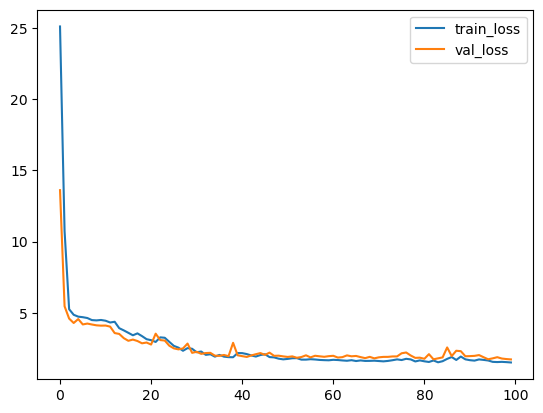

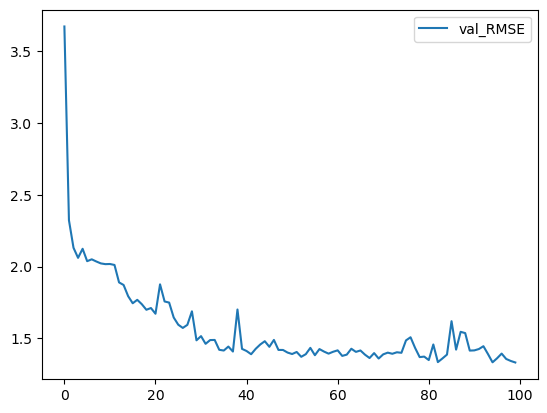

  0%|          | 0/100 [00:00<?, ?it/s]

3.0619514521279947
2.7885748909253008
2.278639121705403
1.959941030227233
1.7001796691055957
1.6348566966137121
1.5557872962118802
1.4738320132503155
1.446071695826923
1.4289253611178774
1.4236201971647526
1.3987637718229124
1.3721275378935227
1.3653570328557267
1.3447809056086764
1.3410760252767164
1.3353188487790795
1.3175002850933213
1.3093608449388314
1.2988850564037366
1.2932647213929254
1.2759502800902116
1.2748651066075736


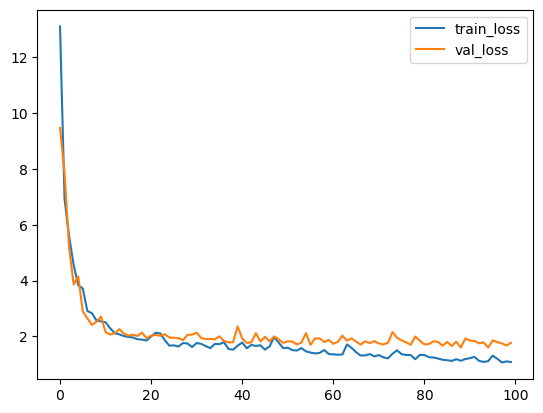

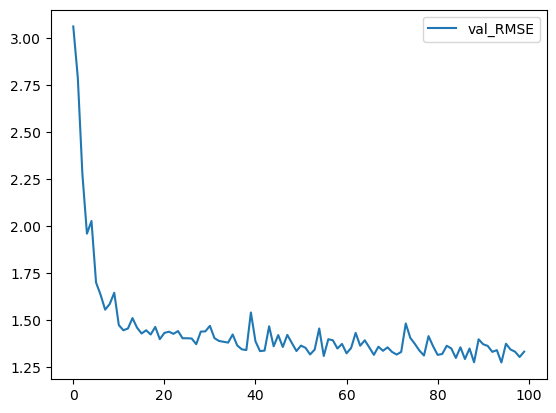

  0%|          | 0/100 [00:00<?, ?it/s]

3.4248614617358384
2.2417864532819123
1.9377127958067846
1.8172015575559735
1.7376216730066372
1.6043495974010271
1.5071078768211192
1.4640979749398828
1.4580783053861162
1.4262510464318545
1.4020451464238373
1.3700631070043667
1.3573055806833456
1.353575867294848
1.3136685839197957
1.2999142229986083
1.2912822580199468
1.2769142918356098
1.2383999337835876
1.2284916477527832
1.2265429540132555
1.1538638353389448
1.1371895540931685


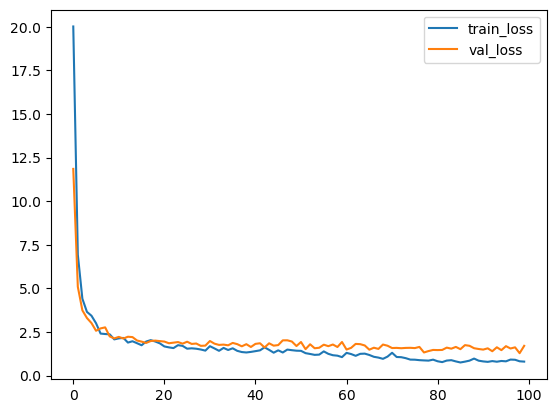

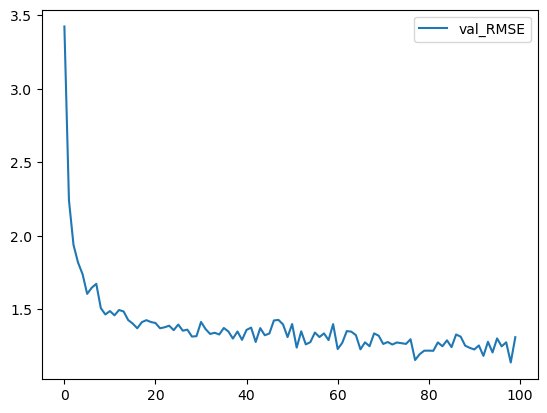

GraphNeuralNetwork(
  (myAttentionModule): MyAttentionModule4(
    (gates): ModuleDict(
      (AtomicNum): GINConv(nn=Sequential(
        (0): Linear(in_features=12, out_features=1, bias=True)
        (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=1, out_features=1, bias=True)
        (4): ReLU()
      ))
      (Degree): GINConv(nn=Sequential(
        (0): Linear(in_features=6, out_features=1, bias=True)
        (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=1, out_features=1, bias=True)
        (4): ReLU()
      ))
      (TotalNumHs): GINConv(nn=Sequential(
        (0): Linear(in_features=5, out_features=1, bias=True)
        (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Linear(in_features=1, out_features=1, bias=True)
        (4): ReLU()
 

<Figure size 640x480 with 0 Axes>

In [32]:
######################## wizualizacje #################################################
m = GraphNeuralNetwork(512, my_layer=MyAttentionModule4(3), features_after_layer=3)
visualize(m, train_loader, valid_loader, test_loader, epochs=100, saveImg=True, title="MyAttentionModule4(3)_esol")

m = GraphNeuralNetwork(512, my_layer=MyAttentionModule4(35), features_after_layer=35)
visualize(m, train_loader, valid_loader, test_loader, epochs=100, saveImg=True, title="MyAttentionModule4(35)_esol")

m = GraphNeuralNetwork(512, my_layer=MyAttentionModule4(100), features_after_layer=100)
visualize(m, train_loader, valid_loader, test_loader, epochs=100, saveImg=True, title="MyAttentionModule4(100)_esol")

In [33]:
######################## tabelka ##########################################################
df = pd.DataFrame({"Repr 1": [], "Repr 10": [],
                   "Atention Pooling v2 - size = 3": [], "Atention Pooling v2 - size = 35": [], "Atention Pooling v2 - size = 100": []})
pd.set_option("display.precision", 2)
n_times = 1

for n_convs in [1, 3, 5]:
    for n_channels in [64, 512]:
        row = []

        #########################
        scores = []
        for _ in range(n_times):
            m =  GraphNeuralNetwork(n_channels, n_convs=n_convs, features_after_layer=26)
            m = train_best(m, train_loader1, valid_loader1, epochs=70)
            predictions, att = predict(m, test_loader1)
            rmse_score = rmse(y_test, predictions.flatten())
            scores.append("{:.2f}".format(rmse_score))
        row.append(" | ".join(scores))

        #########################
        scores = []
        for _ in range(n_times):
            m =  GraphNeuralNetwork(n_channels, n_convs=n_convs, features_after_layer=25)
            m = train_best(m, train_loader10, valid_loader10, epochs= 70)
            predictions, att = predict(m, test_loader10)
            rmse_score = rmse(y_test, predictions.flatten())
            scores.append("{:.2f}".format(rmse_score))
        row.append(" | ".join(scores))

        #########################
        for vect_size in [3, 35, 100]:
            scores = []
            for _ in range(n_times):
                m =  GraphNeuralNetwork(n_channels, n_convs=n_convs, my_layer=MyAttentionModule4(vect_size), features_after_layer=vect_size)
                m = train_best(m, train_loader, valid_loader, epochs=70)
                predictions, att = predict(m, test_loader)
                rmse_score = rmse(y_test, predictions.flatten())
                scores.append("{:.2f}".format(rmse_score))
            row.append(" | ".join(scores))

        df.loc[str(n_convs) + " convs, " + str(n_channels) + " channels"] = row

df.to_csv("esol_out.csv")

  0%|          | 0/70 [00:00<?, ?it/s]

1.9507153235632513
1.9336070765198485
1.8020398369157058
1.7451619325818972
1.7217920955216837
1.6459449869575147
1.6063797811148937
1.5136445502637543
1.5069087194759647
1.4623850255994166
1.4602010399483347
1.4430459117954815
1.4060155950246973
1.3979096665072175
1.3959800161115443
1.3834560199754853
1.3503205421283928


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.040449674607077
1.9990387934464975
1.9314496636167051
1.7771565661091726
1.701324785364343
1.6449128343178203
1.6109751994019226
1.5257622608714696
1.4903172879242397
1.46389018306975
1.4342442096364971
1.397287399774622
1.3715533322501603


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.690163815159509
2.270544453609616
1.9940338680327325
1.9727552282176881
1.934984344747194
1.899994970547648
1.860774170773132
1.8342236603308848
1.8026550134903743
1.7859236751545502
1.770756387684595
1.7616279356368132
1.737797189950935
1.7058093369041187
1.6952512426491542
1.6402220687272313
1.6128092613866887
1.5870159294326989
1.5452800177313064
1.5179611292224786
1.4947919375634686
1.4666263418214074
1.4590299178619863
1.4587807553520309
1.4330621721513201
1.4310922313807626
1.422751201563501
1.397723193784015
1.388677371867467
1.3810083281699392
1.3684451620957463
1.3610942889778594


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.2058123620147683
2.108326334777673
1.9423605336162895
1.8425389343921035
1.7288628260983714
1.6416160013292886
1.6407796348134582
1.5590929839813341
1.5479750163411492
1.5390583031751188
1.522839751037504
1.5006555240408193
1.4884594647922222
1.4739670834060012
1.466810690189429
1.4433470263355017
1.3939705548305954
1.3884410645788892
1.3744770465709468
1.3696294726556237
1.3531780102166269
1.3459221967777424
1.3361875605796847


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.06041886335484
1.9812661805517087
1.8956192670799894
1.8249309493999133
1.7975369235561747
1.6644309032934883
1.6097761291018462
1.6004326862692304
1.5627985120822754
1.4844340905920417
1.4467170963365799
1.4048022080878009
1.4038943290017987
1.390304199940757
1.3898626340732914
1.3742956951523768
1.3502070595781615
1.330506902303553
1.3278962916708144


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.936115760155548
1.9157316440775218
1.6773406408079208
1.5308898842749745
1.5105765422785449
1.4400990577355255
1.4271868870790174
1.3852198214977192
1.3741617388049423
1.3709232702533882
1.362969987254123


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

1.8643803853319847
1.7748274011914371
1.5795396995499744
1.4764933341941373
1.4505314656895476
1.449635345075455
1.445715666330841
1.4384517330996218
1.4069882735653705
1.3983750056013171
1.3911827494205207


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.4980291535961863
2.1856174220330282
1.9671087732714905
1.9437312589388138
1.9049592155225756
1.878839102151777
1.8536757210899935
1.850519593518621
1.832922805702778
1.750067262260857
1.7044612693457921
1.6194761576587717
1.6154067035100588
1.5670701477519735
1.5593298612250344
1.5063981639664978
1.4802819383406312
1.460958559595057
1.413291130651131
1.3973993990044586
1.3939066637041915
1.3713114562836526
1.3617410535616512
1.3561524420405053
1.3551033033770505
1.3338489956829997
1.329722063481119
1.319827986372981
1.3101208570521
1.3030588080779746
1.2875402125868314


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.198855703376565
1.9083248532572572
1.9057681694839366
1.8284427040674072
1.769716736424676
1.6801426032910507
1.6001127577246639
1.4946302527672681
1.4487989702966206
1.3942801184622422
1.3670773456855574
1.36497797119824
1.3578466637713416
1.3420186370809994


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.196872764133579
1.985070880030359
1.8029430419990482
1.7446481161794951
1.6894295617115545
1.6311588570636322
1.5066950036317592
1.41723939269863
1.4060188049494906
1.384407661575802
1.3680763982383535
1.3675013824379156
1.361047143041858
1.3493701577801291
1.3320351583017773
1.3064851804692894


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.126309205203446
1.864782025223601
1.738336437358322
1.6342229920002196
1.5405349332030227
1.4649649320610394
1.4262729470821032
1.4047561932191155
1.401182616894402
1.387945550021808
1.3792988539059732
1.3607168034625619
1.3589577600027698
1.3585872722999426
1.3446514262714169
1.3422339605516644
1.3421369008943456
1.3394623931415675
1.3348557137175778
1.3247574682830638


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.1958081399302296
2.0579795936672056
1.816715709715082
1.6489205637272382
1.5666839302288664
1.4802335527714285
1.4796771952581933
1.4767478069981235
1.4138527332061372
1.394100925391277
1.3807341862307887
1.3710267476677906
1.358764530927332
1.3418697172281728
1.3284784659784101
1.325133665316316
1.2916621882643473
1.261846832024197


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.033348833462704
1.9876776987666809
1.933019024173618
1.7076210038809039
1.6791880816492482
1.5594528320829937
1.5094001668550758
1.4305005719388217
1.4234606052234264
1.4163100610314847
1.4040508536155774
1.3953551147821421
1.3785014768214283
1.3772456833641968
1.3617958125507716


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.154742454372726
1.9143701014877719
1.7928688391457488
1.7032417923589058
1.6410751509244437
1.5085857475819884
1.454542536578278
1.448898257632102
1.444662094113019
1.443578328202585
1.4270989912775496
1.4190686837130566
1.402595560542792
1.3870367169678721
1.3760921584398709
1.3688702190900965
1.3498344458272884
1.3431434369805502
1.28646303544707
1.27992439982852
1.2478308368862268


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.5756894353277073
1.8932578631502783
1.8258272650163
1.747286112168328
1.6742208274294754
1.6098838873164996
1.552673323392773
1.4829229381536282
1.4797123174120645
1.460727110290447
1.45787647947848
1.4541821138124846
1.4429731898915672
1.428449277175453
1.4211027011642376
1.4179777398119502
1.3820740991695473
1.37634181749966


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.389347381049767
1.892593250471659
1.7567953936117018
1.6809445522393776
1.5474778241600646
1.4859786818490548
1.469259472080138
1.4415511678894941
1.429821427957469
1.4114728730217598
1.38634183295939
1.3853056823486
1.382740056686463
1.3785763792682426
1.3762642657207962
1.3515808483108083
1.3470017721174088
1.3454005194188055
1.3448447360406874
1.3354925951183996


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.591723212715789
2.240687459460229
2.0018801489916362
1.7657423468182099
1.7038389356394354
1.6682474793882949
1.585055915907317
1.526214278440462
1.5085205876084726
1.5012735297897266
1.4879487807313638
1.4538736138486308
1.4434657424945467
1.4130280524112215
1.391342430160143
1.378065586243266
1.3439544558338161
1.341414249053825
1.3373617403222748
1.3216798045384914
1.3159865791598122


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.6848804933918333
2.071586912249843
2.039980422813888
2.014061381602108
1.9634588646357953
1.8942640780924673
1.8393212497272249
1.8295751907158708
1.8275694954905386
1.774773174807732
1.72743516779504
1.7172263730007464
1.7110152690235718
1.6945877290561366
1.6782696623768814
1.6779449770924177
1.6669657555637551
1.607158759304634
1.5533287706918628
1.5288383261160965
1.524878212626171
1.4592234758157665
1.451160262456404
1.4225529458726764
1.4052125779732523
1.3881444073545368
1.367166076293547
1.3627700083616665
1.3573764345696135
1.3309185266298378
1.3256839802504279
1.3204453972046213
1.3174296392325082
1.3151383847444629
1.3146889256565504


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.8040945417673644
2.4159542813892405
1.9303559323121797
1.7793807108924937
1.7388240030778142
1.6338677142538678
1.5771883812734653
1.5310630438881394
1.4935642290437814
1.467161921950416
1.4437828954368679
1.4160240472213854
1.3556800349796694
1.3501053367115585
1.3483120167793845
1.3394940331038983
1.327215840906331
1.315096569411165
1.3007308918423148
1.2884275865870136
1.2761287071249425
1.2728650038673655


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.174256958206232
2.4594508639304955
1.8691894012423305
1.763709596079766
1.6614088946138819
1.6262659959115306
1.5765856929484787
1.5673615664207545
1.533938992780935
1.4859037924452472
1.4270702610658645
1.4167887810706077
1.3389428454194807
1.3354557449693678
1.3009163723207087
1.2771716145923149
1.2740478734916156
1.2668566590290185
1.2502747367015714


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.7188729877205553
1.8991200310147698
1.7249811714474699
1.657293845718564
1.5489746172073828
1.525122863775939
1.4538297044104862
1.4172701068375562
1.4127056491301486
1.4082218001620526
1.3757537988543647
1.3670491969827896
1.3560644616356972
1.3368150426557739
1.3305052676980265
1.3267314182132546
1.3082301702620729
1.2729396546262126


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.303457662872839
1.8357623265563314
1.696953437962782
1.5728928929944563
1.5242257054170278
1.4779989393644077
1.467576887105727
1.4535075908671846
1.425234442957334
1.4019771983968714
1.3804363371037691
1.3489542019503546
1.3419107790601366
1.329942438803476


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.3371943351210884
1.9333736823988836
1.92663902366117
1.9225358080119685
1.812400726661587
1.763215183094616
1.757109887675671
1.6590034203947988
1.651894914816984
1.5927471403060842
1.5678049077939786
1.5582056329650322
1.5550507536813654
1.5291133876056435
1.468704627321427
1.4610399236962759
1.4277315667138717
1.4117211023223626
1.3938708081473743
1.382933800175482
1.3569921486836791
1.3492133921199592
1.3393907457508216


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.053197918579084
1.923328452168918
1.8141837532263048
1.7393610520840288
1.7328566564771037
1.6379143768802502
1.5715171292655927
1.5110440913533374
1.475099634872489
1.41968736153766
1.4038402567427075
1.3760953897301673
1.354880950910239
1.3373525507033805


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.2317758857123664
2.237727691234442
2.134932928900715
1.8976151858702566
1.8635771720073282
1.813847942817427
1.7637421826409312
1.7181024296589655
1.6294011707656686
1.618869277422022
1.613461915949732
1.5631977893391726
1.5415072125473406
1.506106514349331
1.4790338094394575
1.4586970706299187
1.4468469534696473
1.421133344942551
1.4024285442983928
1.3874712341481317
1.3522844683434418
1.3257033334926316
1.303961682488742
1.3015682298543843
1.2945323561541755
1.2892532529947214


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.2883479468962657
2.3733152260898023
2.161604546445929
2.0885896121679934
2.0376841437688733
2.006926732251402
1.9483804456353424
1.8625738753663352
1.7412314802193776
1.6849049413127848
1.583316294518996
1.529298111751304
1.5055606169228002
1.4960365894889203
1.4918390317265797
1.464960485700664
1.4548490341748648
1.429715527840049
1.4271046688072497
1.4231810659239235
1.4208569018683128
1.4192373230483877
1.4039345442343674


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.3689637782842006
2.191472239250746
1.9915136338010502
1.9735104557941037
1.8915466658892341
1.7267299233958535
1.6441133882465033
1.5638685786345128
1.5269426643730544
1.484834797558722
1.4566463846901245
1.4099137158914137
1.4071934130337511
1.373831285991315
1.3709395121372403
1.3537608816640403
1.3524086923976977
1.3512338133313513
1.3438780527576273
1.3345478112308322
1.3325414185822022
1.3270991748372853
1.313682940848314
1.3131396213606443
1.3127841435250405
1.299944409217815
1.2982631323145128


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.6050381131850244
2.6040989339326805
2.1191232653014476
2.0406761446222306
2.0328186752885613
2.0314749677723976
1.9428064111811776
1.853388446051117
1.7238261905613783
1.6683516771508287
1.6273626870395947
1.6171438130296727
1.5923994659231164
1.5341945856841395
1.5316571785661246
1.5248358672619349
1.4777440298444933
1.4684236195195208
1.446122190059374
1.4422282812231857
1.4366211952111383
1.425535430943591


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

2.341732328754608
2.0780485098058756
2.0490589597164157
2.0378976425044395
1.8733706295902428
1.84591578255779
1.7997207686045935
1.7648624799983432
1.732099516602324
1.6874371812471363
1.5350713762613408
1.5336104169776705
1.4411535113524847
1.3948020542044104
1.3812252958336904
1.3532129448515586
1.3318100121574559
1.3235806443868454
1.2990660121550337
1.285662386457239
1.2844286336192554


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

3.6488625403339814
2.465366769682158
2.227499613898839
1.9597275810949073
1.8781643704915416
1.8527602399073182
1.7654759580043813
1.7172088132263303
1.6595447521693178
1.6145950164360432
1.607355008048008
1.5675994558513349
1.5396451575037995
1.515201120731396
1.4770163224287955
1.4165024497876029
1.4157357934293107
1.403301917393331
1.3976333024564487
1.3625174663444468
1.3619700995962125
1.323917495013106
1.3119753025234373
1.3039152644002219
1.3012320135245892
1.2979634374289797
1.2943654012912942
1.2859161164461812
1.2857607306133074


  0%|          | 0/5 [00:00<?, ?it/s]

In [34]:
m =  GraphNeuralNetwork(512, n_convs=3, my_layer=MyAttentionModule4(35), features_after_layer=35)
m = train_best(m, train_loader, valid_loader, epochs=70)
predictions, att = predict(m, test_loader)
rmse_score = rmse(y_test, predictions.flatten())
print("{:.2f}".format(rmse_score))

  0%|          | 0/70 [00:00<?, ?it/s]

3.0227834590960674
2.232227819451916
1.9664097825587499
1.6954093615371726
1.5753249000281524
1.528144112575394
1.5037602970939115
1.4768499217727113
1.4599923489537663
1.4483568674122735
1.4434541112822101
1.4404855911298529
1.4166960942294822
1.4114335745871684
1.404131302328779
1.396338162863882
1.3672435244453955
1.3436487206584198
1.3323085092983822
1.3024006344661614


  0%|          | 0/5 [00:00<?, ?it/s]

1.32


In [35]:
###################### atencja #################################

df_single = pd.DataFrame({"AtomicNum": [], "Degree": [], "TotalNumHs": [], "ImplicitValence": [], "Hybridization": [], "FormalCharge": [],
                          "IsInRing": [], "IsAromatic": [], "NumRadicalElectrons": []})
df_single.style.set_caption("Hello World")

df_batch = pd.DataFrame({"AtomicNum": [], "Degree": [], "TotalNumHs": [], "ImplicitValence": [], "Hybridization": [], "FormalCharge": [],
                          "IsInRing": [], "IsAromatic": [], "NumRadicalElectrons": []})
df_batch.style.set_caption("Hello World")

preds_batches = []
with torch.no_grad():
    for data in test_loader:
        x, edge_index, batch = data.x, data.edge_index, data.batch
        
        preds, att = m(x, edge_index, batch)
        preds_batches.append(preds.cpu().detach().numpy())
        att = att.squeeze()
        df_single.loc[len(df_single)] = att[0].tolist()
        df_batch.loc[len(df_single)] = torch.mean(gap(att, batch), dim=0).tolist()
preds = np.concatenate(preds_batches)

rmse_score = rmse(y_test, predictions.flatten())

print(f'RMSE = {rmse_score:.2f}')
df_single.to_csv("esol_att_single.csv")
df_batch.to_csv("esol_att_batch.csv")

RMSE = 1.32


In [36]:
df_single[:10]

,AtomicNum,Degree,TotalNumHs,ImplicitValence,Hybridization,FormalCharge,IsInRing,IsAromatic,NumRadicalElectrons
0,0.53,0.03,0.03,0.03,0.27,0.03,0.03,0.05,0.03
1,0.17,0.06,0.06,0.08,0.34,0.06,0.06,0.11,0.06
2,0.17,0.06,0.06,0.08,0.34,0.06,0.06,0.11,0.06
3,0.17,0.06,0.06,0.08,0.34,0.06,0.06,0.11,0.06
4,0.17,0.06,0.06,0.08,0.34,0.06,0.06,0.11,0.06


In [37]:
df_batch[:10]

,AtomicNum,Degree,TotalNumHs,ImplicitValence,Hybridization,FormalCharge,IsInRing,IsAromatic,NumRadicalElectrons
1,0.25,0.06,0.06,0.11,0.22,0.06,0.06,0.11,0.06
2,0.24,0.06,0.06,0.11,0.22,0.06,0.06,0.11,0.06
3,0.23,0.07,0.07,0.11,0.22,0.07,0.07,0.11,0.07
4,0.23,0.07,0.07,0.11,0.22,0.07,0.07,0.11,0.07
5,0.23,0.07,0.07,0.11,0.22,0.07,0.07,0.11,0.07


In [38]:
df

,Repr 1,Repr 10,Atention Pooling v2 - size = 3,Atention Pooling v2 - size = 35,Atention Pooling v2 - size = 100
"1 convs, 64 channels",1.47,1.49,1.41,1.38,1.43
"1 convs, 512 channels",1.48,1.50,1.42,1.51,1.37
"3 convs, 64 channels",1.32,1.32,1.35,1.30,1.39
"3 convs, 512 channels",1.31,1.30,1.40,1.26,1.26
"5 convs, 64 channels",1.32,1.31,1.35,1.37,1.32
"5 convs, 512 channels",1.47,1.29,1.46,1.30,1.34


In [39]:
torch.save(m.myAttentionModule.state_dict(), "attention_pooling_esol.pth")